# Keras handout
## [COSC 7336 Advanced Natural Language](https://fagonzalezo.github.io/dl-tau-2017-2/)

In [23]:
import numpy as np
import pylab as pl
from sklearn.datasets.samples_generator import make_moons
import keras

%matplotlib inline

# Functions for plotting 2D data and decision regions

def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")

def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 30)
    y_vals = np.linspace(min_y, max_y, 30)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 30, cmap = pl.cm.coolwarm, vmin= 0, vmax=1)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")

### 1. Neural network training in Keras

We will build a multilayer network to solve the following classification problem:

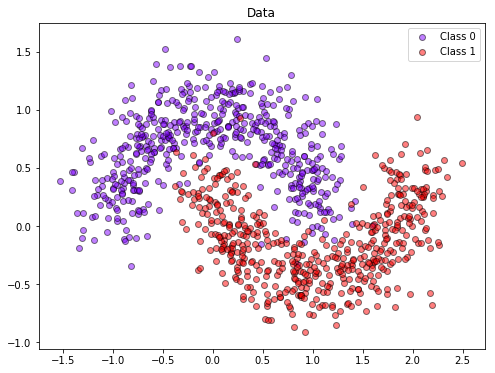

In [24]:
x_train, y_train = make_moons(n_samples=1000, noise= 0.2, random_state=3)
pl.figure(figsize=(8, 6))
plot_data(x_train, y_train)

We define a `Sequential` model. The model is built by stacking layers. The first layer is a dense layer that receives 2 inputs and has 20 neurons with `relu` activation. The second and last layer has a neuron with sigmoid activation.

In [25]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()

model.add(Dense(units=20, input_dim=2))
model.add(Activation('relu'))
model.add(Dense(units=1))
model.add(Activation('sigmoid'))

The structured of the neural network can be visualized with:

In [26]:
model.summary(70)

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_7 (Dense)                (None, 20)                  60         
______________________________________________________________________
activation_7 (Activation)      (None, 20)                  0          
______________________________________________________________________
dense_8 (Dense)                (None, 1)                   21         
______________________________________________________________________
activation_8 (Activation)      (None, 1)                   0          
Total params: 81
Trainable params: 81
Non-trainable params: 0
______________________________________________________________________


The learning process is configured with `compile`. Here we will use a cross-entropy loss function and an SGD optimizer. A the learning process will keep track of the accuracy.

In [27]:
from keras.optimizers import SGD
model.compile(loss = 'binary_crossentropy',
              optimizer = SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=False),
              metrics = ['accuracy'])

The model is trained by calling the function `fit`:

In [28]:
model.fit(x_train, y_train, epochs=100, verbose=2)

Epoch 1/100
0s - loss: 0.6109 - acc: 0.6770
Epoch 2/100
0s - loss: 0.4458 - acc: 0.8030
Epoch 3/100
0s - loss: 0.3726 - acc: 0.8280
Epoch 4/100
0s - loss: 0.3342 - acc: 0.8450
Epoch 5/100
0s - loss: 0.3099 - acc: 0.8660
Epoch 6/100
0s - loss: 0.2929 - acc: 0.8720
Epoch 7/100
0s - loss: 0.2822 - acc: 0.8780
Epoch 8/100
0s - loss: 0.2738 - acc: 0.8780
Epoch 9/100
0s - loss: 0.2682 - acc: 0.8800
Epoch 10/100
0s - loss: 0.2643 - acc: 0.8810
Epoch 11/100
0s - loss: 0.2609 - acc: 0.8820
Epoch 12/100
0s - loss: 0.2589 - acc: 0.8880
Epoch 13/100
0s - loss: 0.2579 - acc: 0.8870
Epoch 14/100
0s - loss: 0.2558 - acc: 0.8890
Epoch 15/100
0s - loss: 0.2551 - acc: 0.8850
Epoch 16/100
0s - loss: 0.2527 - acc: 0.8890
Epoch 17/100
0s - loss: 0.2542 - acc: 0.8840
Epoch 18/100
0s - loss: 0.2521 - acc: 0.8880
Epoch 19/100
0s - loss: 0.2499 - acc: 0.8890
Epoch 20/100
0s - loss: 0.2486 - acc: 0.8920
Epoch 21/100
0s - loss: 0.2474 - acc: 0.8870
Epoch 22/100
0s - loss: 0.2502 - acc: 0.8880
Epoch 23/100
0s - l

The trained model can be use to classify new samples 
using `predict`:

In [29]:
print(model.predict(np.array([[0, 0]])))

[[ 0.98310822]]


This is the decision region of the trained model:

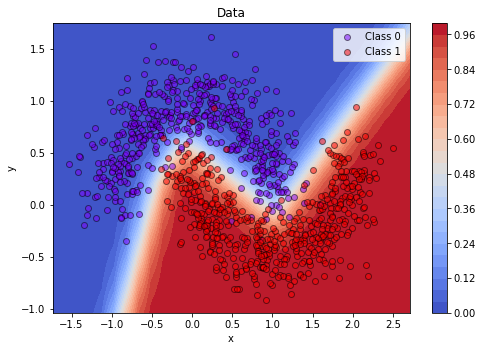

In [30]:
def pred_fun(x1, x2):
        xval = np.array([[x1, x2]])
        return model.predict(xval)[0, 0]

pl.figure(figsize = (8,16/3))    
plot_decision_region(x_train, pred_fun)
plot_data(x_train, y_train)

### 2. Training a text classifier

We will create a model to classifiy Reuters newswires
according to their topic. The original dataset is available [here](https://archive.ics.uci.edu/ml/datasets/reuters-21578+text+categorization+collection), but Keras has functions that facilitate the task of loading and preprocessing it.

In [31]:
from keras.datasets import reuters
from keras.layers import Dropout
from keras.preprocessing.text import Tokenizer

max_words = 1000

print('Loading data...')
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=max_words,
                                                         test_split=0.2)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

num_classes = np.max(y_train) + 1
print(num_classes, 'classes')


Loading data...
8982 train sequences
2246 test sequences
46 classes


Is instance is represented by a sequence of numbers which correspond to indices of the corresponding words.

In [32]:
print(x_train[101])

[1, 2, 149, 8, 25, 2, 400, 304, 200, 6, 337, 4, 342, 2, 2, 7, 2, 2, 9, 4, 342, 643, 2, 7, 2, 4, 88, 2, 31, 4, 384, 292, 211, 5, 2, 978, 220, 33, 851, 2, 11, 15, 9, 447, 7, 42, 92, 131, 276, 5, 156, 11, 15, 50, 33, 30, 2, 7, 2, 383, 29, 336, 25, 383, 29, 2, 94, 156, 4, 49, 8, 7, 788, 4, 88, 33, 2, 747, 11, 15, 197, 92, 222, 825, 5, 934, 11, 15, 2, 8, 17, 12]


The map for word to index is also provided, so it is possible to decode the instance back to text:

In [33]:
word_index = reuters.get_word_index(path="reuters_word_index.json")
num_words = max(word_index.values()) + 1
words = ['']*num_words
for word in word_index:
    words[word_index[word]] = word
print([words[i-2] for i in x_train[101][1:]])

['', 'dlr', 'and', 'cts', '', '80', 'average', 'companies', 'in', 'income', 'of', 'make', '', '', 'said', '', '', 'a', 'of', 'make', '52', '', 'said', '', 'of', '1987', '', '2', 'of', 'sold', 'general', 'states', 'to', '', 'field', 'securities', 'was', 'agricultural', '', '3', 'it', 'a', '1988', 'said', 'as', 'april', '50', 'term', 'to', 'earlier', '3', 'it', 'but', 'was', 'with', '', 'said', '', 'previously', 'be', 'sell', 'cts', 'previously', 'be', '', 'more', 'earlier', 'of', 'which', 'and', 'said', 'commerce', 'of', '1987', 'was', '', 'august', '3', 'it', 'export', 'april', 'report', 'vice', 'to', 'beef', '3', 'it', '', 'and', '000', 'for']


Data is encoded using a bag of words representation, i.e. a matrix of size num of instances by vocabulary size

In [34]:
tokenizer = Tokenizer(num_words=max_words)
x_train = tokenizer.sequences_to_matrix(x_train, mode='binary')
x_test = tokenizer.sequences_to_matrix(x_test, mode='binary')
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (8982, 1000)
x_test shape: (2246, 1000)


Labels are converted to one-hot representation:

In [35]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

y_train shape: (8982, 46)
y_test shape: (2246, 46)


Now we build a dense neural network with one hidden layer:

In [37]:
model = Sequential()
model.add(Dense(256, input_shape=(max_words,)))
model.add(Activation('sigmoid'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_11 (Dense)               (None, 256)                 256256     
______________________________________________________________________
activation_11 (Activation)     (None, 256)                 0          
______________________________________________________________________
dense_12 (Dense)               (None, 46)                  11822      
______________________________________________________________________
activation_12 (Activation)     (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________


We configure the learning task to use SGD as optimization:

In [38]:
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])


Now we can train the model using a 0.1 training validation split:

In [39]:
batch_size = 32
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 1s - loss: 2.4065 - acc: 0.3583 - val_loss: 2.3032 - val_acc: 0.4004
Epoch 2/5
8083/8083 [==============================] - 1s - loss: 2.1747 - acc: 0.4372 - val_loss: 2.1845 - val_acc: 0.4082
Epoch 3/5
8083/8083 [==============================] - 1s - loss: 2.0639 - acc: 0.4841 - val_loss: 2.0845 - val_acc: 0.4883
Epoch 4/5
8083/8083 [==============================] - 1s - loss: 1.9834 - acc: 0.5074 - val_loss: 2.0184 - val_acc: 0.4994
Epoch 5/5
8083/8083 [==============================] - 1s - loss: 1.9196 - acc: 0.5191 - val_loss: 1.9562 - val_acc: 0.5128


Finally, we test the performance over the test set:

In [40]:
score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

2144/2246 [===========================>..] - ETA: 0sTest score: 1.91597595516
Test accuracy: 0.529830810356


The performance is not very good, but in the in-class activity we'll improve it!